# The TransformedDistribution class

> In this post, we are going to take a look at transform distribution objects as a module. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/transformed_dist.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

The transformedDistribution is sort of distribution that can be defined by another base distribution and a bijector object. Tensorflow Probability offers [transformed distribution](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution) object with consistent API that can use same methods and properties of other distribution.

In [3]:
normal = tfd.Normal(loc=0., scale=1.)
z = normal.sample(3)
z

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.270398  ,  0.18898423, -0.73362327], dtype=float32)>

In [4]:
scale_and_shift = tfb.Chain([tfb.Shift(1.), tfb.Scale(2.)])
x = scale_and_shift.forward(z)
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.5407958 ,  1.3779684 , -0.46724653], dtype=float32)>

In [5]:
log_prob_z = normal.log_prob(z)
log_prob_z

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.4962916, -0.936796 , -1.18804  ], dtype=float32)>

In [8]:
log_prob_x = (log_prob_z - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0))
log_prob_x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.189439 , -1.6299431, -1.8811872], dtype=float32)>

Note that, the `event_ndims` argument means the number of rightmost dimensions of z make up the event shape. So in the above case, the log of the jacobian determinant is calculated for each element of the tensor z.

Or we express it with the inverse of the bijective transformation.

In [9]:
log_prob_x = (log_prob_z + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0))
log_prob_x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.189439 , -1.6299431, -1.8811872], dtype=float32)>

The result is the same as while using inverse of x.

In [10]:
log_prob_x = (normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0))
log_prob_x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.189439 , -1.6299431, -1.8811872], dtype=float32)>

You may notice that log probability of x can be calculated with only using z or x. In practice, most of cases uses second expression. The reason is that the z is from base distriubtion. So in terms of analysis, it is the latent variable. But x is from the data distribution, and it is the output from transformed distribution. While using mentioned approach, we can express transform object with bijector or invertible, it can be learned with best parameters for maximum likelihood.

```python
# Base distribution                  Transformation                    Data distribution 
# z ~ P0                <=>               x = f(z)            <=>            x ~ P1

log_prob_x = (base_dist.log_prob(bijector.inverse(x)) + bijector.inverse_log_det_jacobian(x, event_ndims=0))

### Training 

x_sample = bijector.forward(base_dist.sample())
```

In [12]:
normal = tfd.Normal(loc=0., scale=1.)
z = normal.sample(3)
z

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.1660839 , 0.26298988, 0.80137837], dtype=float32)>

In [13]:
exp = tfb.Exp()
x = exp.forward(z)
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.2093997, 1.3008136, 2.2286105], dtype=float32)>

In [14]:
log_normal = tfd.TransformedDistribution(normal, exp)
log_normal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

Above expression is same with like this,

In [15]:
log_normal = exp(normal)
log_normal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

In [16]:
log_normal.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=1.4088374>

In [17]:
log_normal.log_prob(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.7648983, -1.2165103, -2.0414205], dtype=float32)>

We can also define specific `event_shape` and `batch_shape` for transformedDistribtion.

In [20]:
normal = tfd.Normal(loc=0., scale=1.)
scale_tril = [[1., 0.], [1., 1.]]
scale = tfb.ScaleMatvecTriL(scale_tril=scale_tril)

In [22]:
# Multivariate Normal distribution
mvn = tfd.TransformedDistribution(tfd.Sample(normal, sample_shape=[2]), scale)
mvn

<tfp.distributions.TransformedDistribution 'scale_matvec_trilSampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [24]:
scale_tril = [[[1., 0.], [1., 1.]], [[0.5, 0.], [-1., 0.5]]]
scale = tfb.ScaleMatvecTriL(scale_tril=scale_tril)

mvn = tfd.TransformedDistribution(tfd.Sample(tfd.Normal(loc=[0., 0.], scale=1.), sample_shape=[2], ), scale)
mvn

<tfp.distributions.TransformedDistribution 'scale_matvec_trilSampleNormal' batch_shape=[2] event_shape=[2] dtype=float32>

## Tutorial

### TransformedDistribution

In [25]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [26]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [27]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [28]:
# Exponential bijector
exp = tfb.Exp()

In [30]:
# log normal transformed distribution using exp bijector and normal distribution

log_normal_td = exp(normal)

In [31]:
# Display event and batch shape

print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)

batch shape:  ()
event shape:  ()


In [32]:
# Base distribution

z = normal.sample(n)

### Plots

In [33]:
# Plot z density

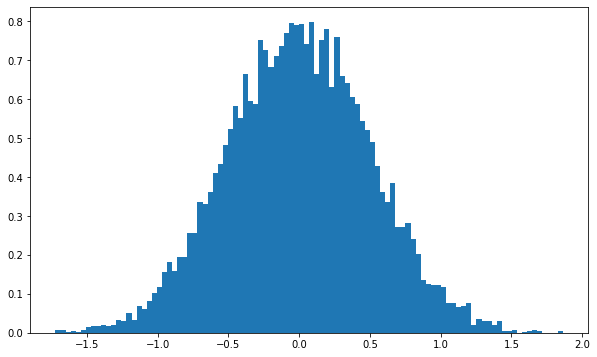

In [34]:
plt.hist(z.numpy(), bins=100, density=True)
plt.show()

In [35]:
# Transformed distribution

x = log_normal_td.sample(n)

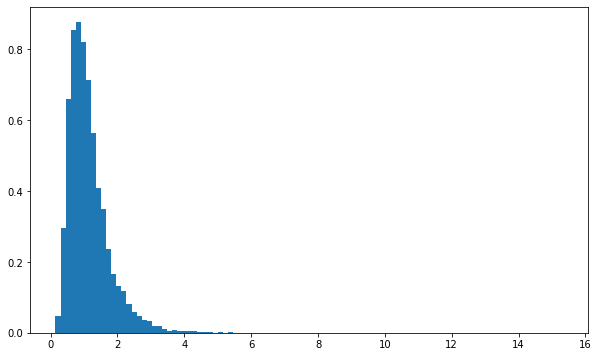

In [36]:
# Plot x density
plt.hist(x.numpy(), bins=100, density=True)
plt.show()

In [37]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)
l = log_normal.sample(n)

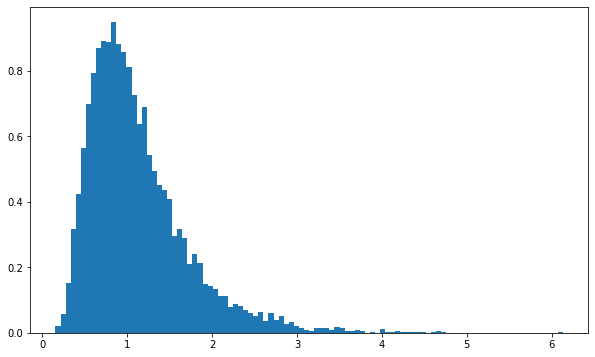

In [38]:
plt.hist(l.numpy(), bins=100, density=True)
plt.show()

### Log probability

In [40]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [41]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [42]:
# Check log probs

tf.norm(log_prob - log_prob_td)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Event shape and batch shape

In [43]:
# Set a scaling lower triangular matrix

tril = tf.random.normal((2, 4, 4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril)

In [45]:
# view of scale_low_tri

scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[-0.71624756,  0.        ,  0.        ,  0.        ],
        [ 0.5268538 , -1.0188125 ,  0.        ,  0.        ],
        [ 0.76072276, -0.5344736 ,  0.4067452 ,  0.        ],
        [ 0.43506932, -0.8857401 , -1.8538325 ,  1.9112511 ]],

       [[-1.3100191 ,  0.        ,  0.        ,  0.        ],
        [ 0.6303728 ,  0.42918292,  0.        ,  0.        ],
        [ 1.1252751 , -0.66470486, -0.71725285,  0.        ],
        [ 2.2047887 , -0.48715273, -0.694466  , -1.1677382 ]]],
      dtype=float32)>

In [46]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [50]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(tfd.Sample(tfd.Normal(loc=[0., 0.], scale=1.), sample_shape=[4]), scale_lin_op)

In [51]:
# Display event and batch shape

print('batch shape: ', mvn.batch_shape)
print('event shape: ', mvn.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [52]:
# Sample

y1 = mvn.sample(sample_shape=(n,))
print(y1.shape)

(10000, 2, 4)


In [53]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tri)
mvn2

<tfp.distributions.MultivariateNormalLinearOperator 'MultivariateNormalLinearOperator' batch_shape=[2] event_shape=[4] dtype=float32>

In [54]:
# sample
y2 = mvn2.sample(sample_shape=(n, ))
y2.shape

TensorShape([10000, 2, 4])

In [55]:
# Check

xn = normal.sample((n, 2, 4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn)) / tf.norm(mvn.log_prob(xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>